<a href="https://colab.research.google.com/github/konkall/Netflix_data_mining/blob/main/NetflixDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Netflix Data Analysis

In this project we are going to explore a dataset that contains Movies/TV Series that are available in the popular streaming platform "Netflix". 

In the first part of this project we're going to visualize some data based on a number of queries that are available below. In the second part we will try to extract useful information from our data in order to build a recommendation system.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Import Libraries

In [3]:
# For large and multi-dimensional arrays
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

# For data manipulation and analysis
import pandas as pd
pd.options.mode.chained_assignment = None

# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt


import nltk
nltk.download('punkt')
nltk.download(u'stopwords')
#Word Tokenization
from nltk import word_tokenize

#Removing Stop Words
from nltk.corpus import stopwords

#Stemming
from nltk.stem import PorterStemmer


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

from sklearn.metrics.pairwise import cosine_similarity



%matplotlib inline


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Load Dataset

In [4]:
Location = r'/content/gdrive/MyDrive/DataMining/Εργασίες/Data Mining Netflix/data/netflix_titles.csv' # Τo r κάνει escape όλους τους χαρακτήρες στην συμβολοσειρά

df = pd.read_csv(Location)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


show_id  ...                                        description
0      s1  ...  In a future where the elite inhabit an island ...
1      s2  ...  After a devastating earthquake hits Mexico Cit...
2      s3  ...  When an army recruit is found dead, his fellow...
3      s4  ...  In a postapocalyptic world, rag-doll robots hi...
4      s5  ...  A brilliant group of students become card-coun...

[5 rows x 12 columns]

#Preprocessing

The preprocessing of our data will take place before executing each query. This is because we need to take into consideration the nature of each question before deciding how to proprocess our dataset.

#Visualization Queries

## Query 1
What type of media is hosted more in Netflix, Movies or TV Series?

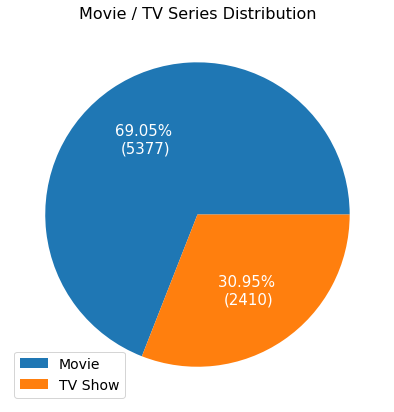

In [ ]:
tempdf = df

types_count = tempdf.groupby(['type']).size().to_numpy()
tempdf = tempdf.groupby(['type']).size()

plt.figure(figsize= (7,7))
tempdf.plot.pie(textprops={'fontsize':15,'color':'white'}, autopct = lambda p : '{:.2f}% \n({:.0f})'.format(p, (p/100)*types_count.sum()))
plt.title('Movie / TV Series Distribution', fontsize = 16)
plt.axis('off')
plt.legend(labels = tempdf.index, prop={"size":14}, loc='lower left')
plt.show()

##Query 2
In the last few years Netflix invests more in Movies or TV Series?

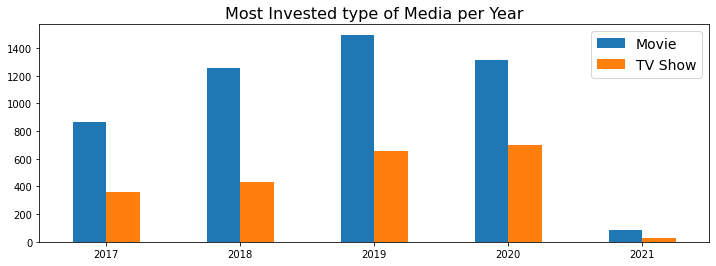

In [ ]:
tempdf = df

#Preprocessing: Deleting rows that contain a NaN value under "date_added"
tempdf.dropna(subset = ["date_added"], inplace=True)
tempdf = tempdf.reset_index()

#Changes the date_added column date format from "M D, Y" to "Y"
tempdf['date_added'] = tempdf['date_added'].str[-4:]

#Groups our data by 'date_added' and 'type' and keeps the last 5 years
inv_media = tempdf.groupby(['date_added', 'type']).size()
inv_media = inv_media.tail(10)

#Prints our data as a bar
inv_media.unstack().plot.bar(figsize= (12,4))
plt.title('Most Invested type of Media per Year', fontsize = 16)
plt.xticks(rotation = 0)
plt.xlabel('', fontsize = 14)
plt.legend(prop={"size":14})
plt.show()

##Query 3
Which country has the most content?

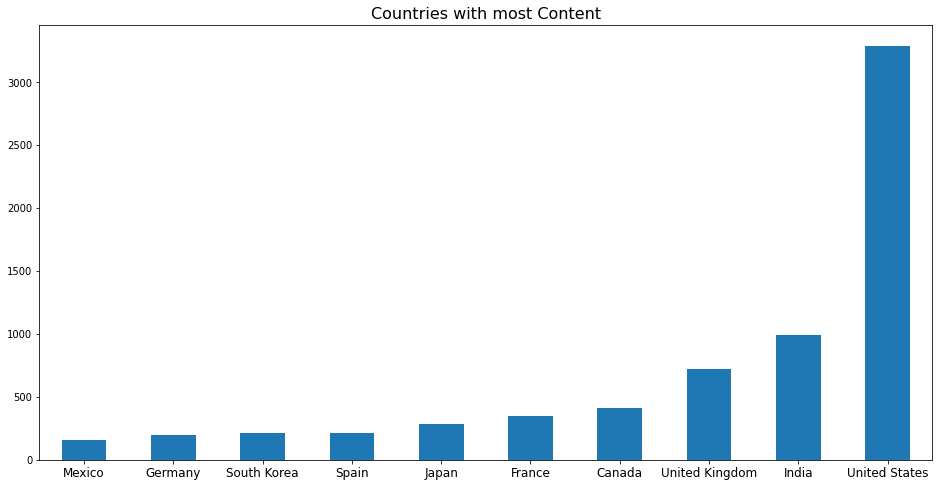

In [ ]:
tempdf = df

#Preprocessing: Deleting rows that contain a NaN value under "country"
tempdf.dropna(subset = ["country"], inplace=True)
tempdf = tempdf.reset_index()

#The 'country' column sometimes has multiple countries in the same entry, so we need to create a seperate row for each country
new_tempdf = tempdf.assign(country=tempdf['country'].str.strip(',').str.replace(', ', ',').str.split(',')).explode('country').reset_index()

#We group our data based on the country and keep the 10 countries with the most content
new_tempdf = new_tempdf.groupby('country').size().sort_values().tail(10)

#We plot our data
new_tempdf.plot.bar(figsize = (16,8))
plt.title('Countries with most Content', fontsize = 16)
plt.xticks(rotation = 0, fontsize = 12)
plt.xlabel('', fontsize = 14)
plt.show()

##Query 4
What kind of content each country has?

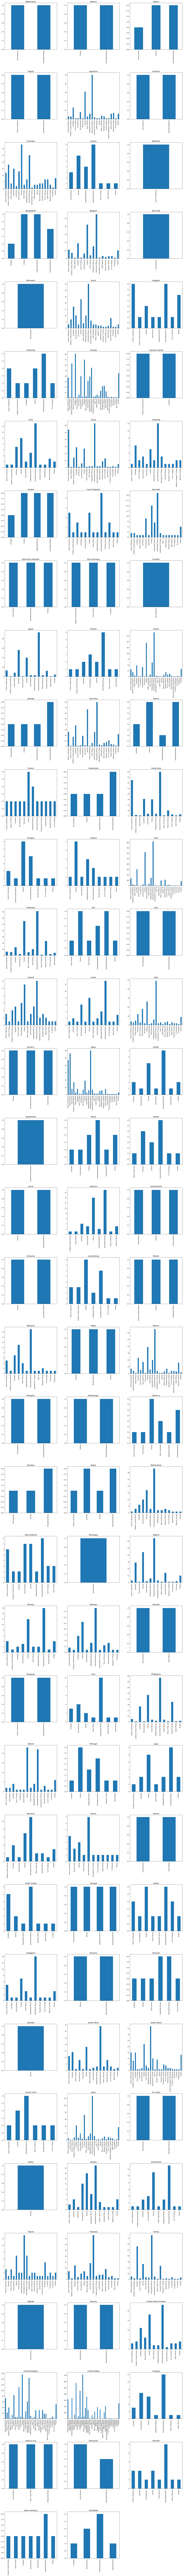

In [ ]:
tempdf = df

#Preprocessing: Deleting rows that contain a NaN value under "country"
tempdf.dropna(subset = ["country"], inplace=True)
tempdf = tempdf.reset_index()

#The 'country' & 'listed_in' columns have multiple entries in the same row, so we need to create a seperate row for each entry
new_tempdf = tempdf.assign(country=tempdf['country'].str.strip(',').str.replace(', ', ',').str.split(',')).explode('country').reset_index()
tempdf =  new_tempdf.assign(listed_in=new_tempdf['listed_in'].str.strip(',').str.replace(', ', ',').str.split(',')).explode('listed_in').reset_index(drop=True)



#We group our data based on the country and keep the 10 countries with the most content
tempdf = tempdf.groupby(['country','listed_in']).size().unstack()

fig = plt.figure(figsize = (25, 400))


i=1
for country, row in tempdf.iterrows():
  row = row.dropna()
  
  ax = fig.add_subplot(40, 3, i)

  row.plot.bar() 
  ax.set_title(country, fontsize = 14)
  ax.set_xlabel('')
  i+=1
  

plt.subplots_adjust(hspace = 0.5)
plt.show()


##Query 5
Who are the actors with the most movies per country?

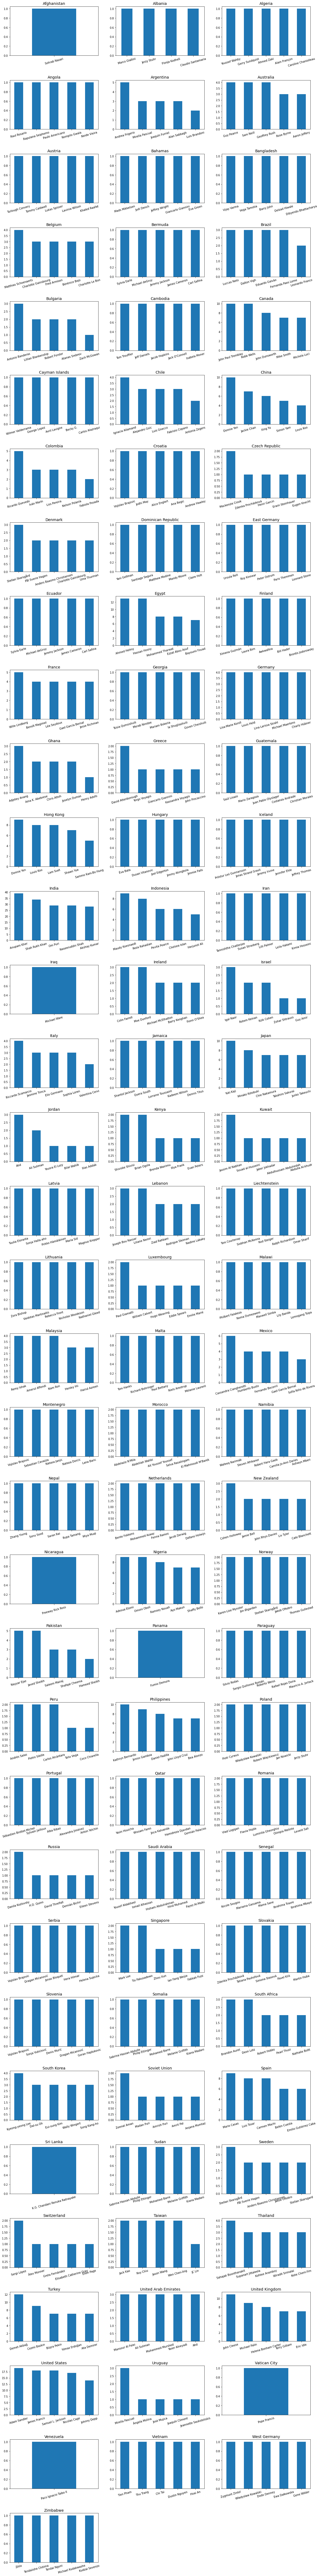

In [ ]:
tempdf = df

#Preprocessing: Deleting rows that contain a NaN value under "country" and "cast"
tempdf.dropna(subset = ["country","cast"], inplace=True)
tempdf = tempdf.reset_index()


#The 'country' & 'cast' columns have multiple entries in the same row, so we need to create a seperate row for each entry
new_tempdf = tempdf.assign(country=tempdf['country'].str.strip(',').str.replace(', ', ',').str.split(',')).explode('country').reset_index(drop=True)
tempdf =  new_tempdf.assign(cast=new_tempdf['cast'].str.strip(',').str.replace(', ', ',').str.split(',')).explode('cast').reset_index(drop=True)

#Keep only the rows that contain movies
tempdf_filtered = tempdf[tempdf['type'] == 'Movie']


# #We group our data based on the country and cast
tempdf_filtered = tempdf_filtered.groupby(['country','cast']).size().unstack()


fig = plt.figure(figsize = (20, 200))


i=1
for country, row in tempdf_filtered.iterrows():
  #Clear NaN values, sort and keep the 5 tops actors with the most movies
  row = row.dropna()
  row = row.sort_values(ascending=False).head(5)
  
  ax = fig.add_subplot(40, 3, i)

  row.plot.bar() 
  ax.set_title(country, fontsize = 14)
  ax.set_xlabel('')
  ax.tick_params('x', labelrotation = 15)
  i+=1
  

plt.subplots_adjust(hspace = 0.5)
plt.show()


##Query 6
What is the number of Movies per suggested age group?

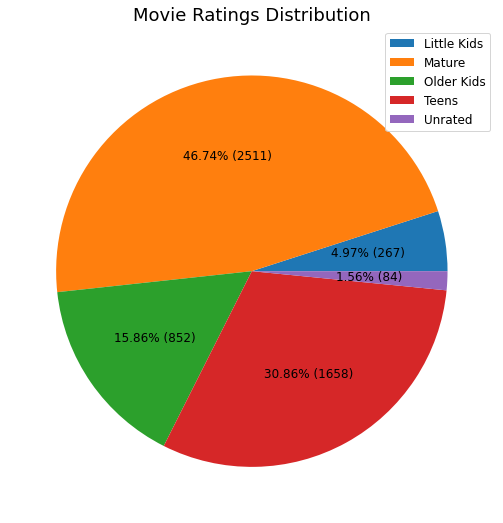

In [ ]:
tempdf = df


Little_Kids = ['G', 'TV-Y', 'TV-G']
Older_Kids = ['PG', 'TV-Y7', 'TV-Y7-FV', 'TV-PG']
Teens = ['PG-13', 'TV-14']
Mature = ['R', 'NC-17', 'TV-MA']
Unrated = ['UR', 'NR']

ratings = [Little_Kids, Older_Kids, Teens, Mature, Unrated]
ratings_name = ['Little Kids','Older Kids','Teens','Mature', 'Unrated']

#Preprocessing: Deleting rows that contain a NaN value under "rating"
tempdf.dropna(subset = ["rating"], inplace=True)
tempdf = tempdf.reset_index()

#Keep only the rows that contain movies
tempdf_filtered = tempdf[tempdf['type'] == 'Movie'].reset_index()

#tempdf_filtered.rating.isin(Little_Kids)

#Replacing ratings with the respective category they fall in
for idx, rating in enumerate(ratings):
  tempdf_filtered.loc[tempdf_filtered.rating.isin(rating), 'rating'] = ratings_name[idx]

#Grouping by 'type' and 'rating'
tempdf_filtered = tempdf_filtered.groupby(['type','rating']).size()
ratings_count = tempdf_filtered.to_numpy()

#Sorting the ratings_name list in order to match the order the data appear in "tempdf_filtered"
ratings_name.sort()

plt.figure(figsize= (9,9))
plt.pie(ratings_count, textprops={'fontsize':12,'color':'black'}, autopct = lambda p : '{:.2f}% ({:.0f})'.format(p, (p/100)*ratings_count.sum()))
plt.title('Movie Ratings Distribution', fontsize = 18)
plt.axis('off')
plt.legend(labels = ratings_name, prop={"size":12})
plt.show()

##Query 7
What's the amount of content added per month?

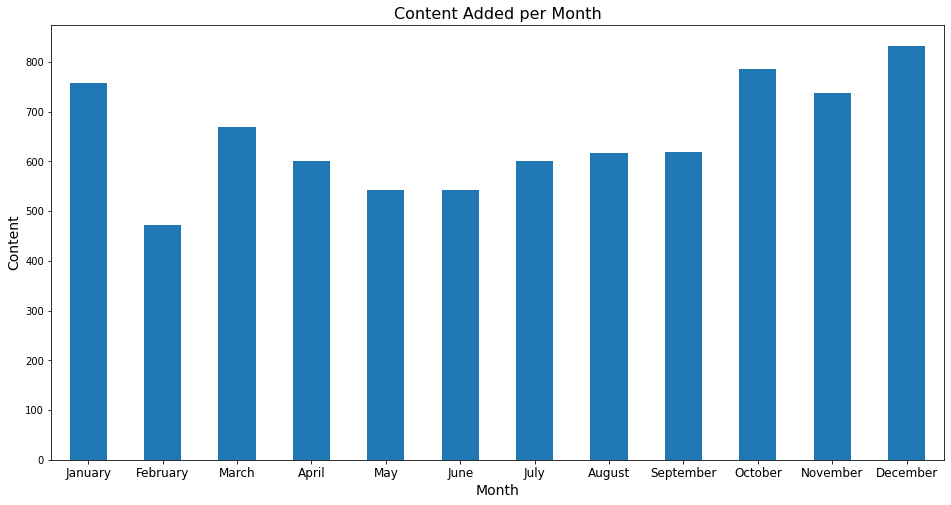

In [ ]:
tempdf = df

months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

#Preprocessing: Deleting rows that contain a NaN value under "date_added"
tempdf.dropna(subset = ["date_added"], inplace=True)
tempdf = tempdf.reset_index()


#Changes the date_added column date format from "M D, Y" to "Y"
tempdf['date_added'] = tempdf['date_added'].str.split().str[0]

#We apply "categorical" so that we'll have the months in the "correct" order when sorted
tempdf['date_added'] = pd.Categorical(tempdf['date_added'], categories=months, ordered=True)

tempdf = tempdf.groupby('date_added').size()

#We plot our data
tempdf.plot.bar(figsize = (16,8))
plt.title('Content Added per Month', fontsize = 16)
plt.xticks(rotation = 0, fontsize = 12)
plt.xlabel('Month', fontsize = 14)
plt.ylabel('Content', fontsize = 14)

plt.show()

##Query 8
How much content for each genre is available in Netflix?

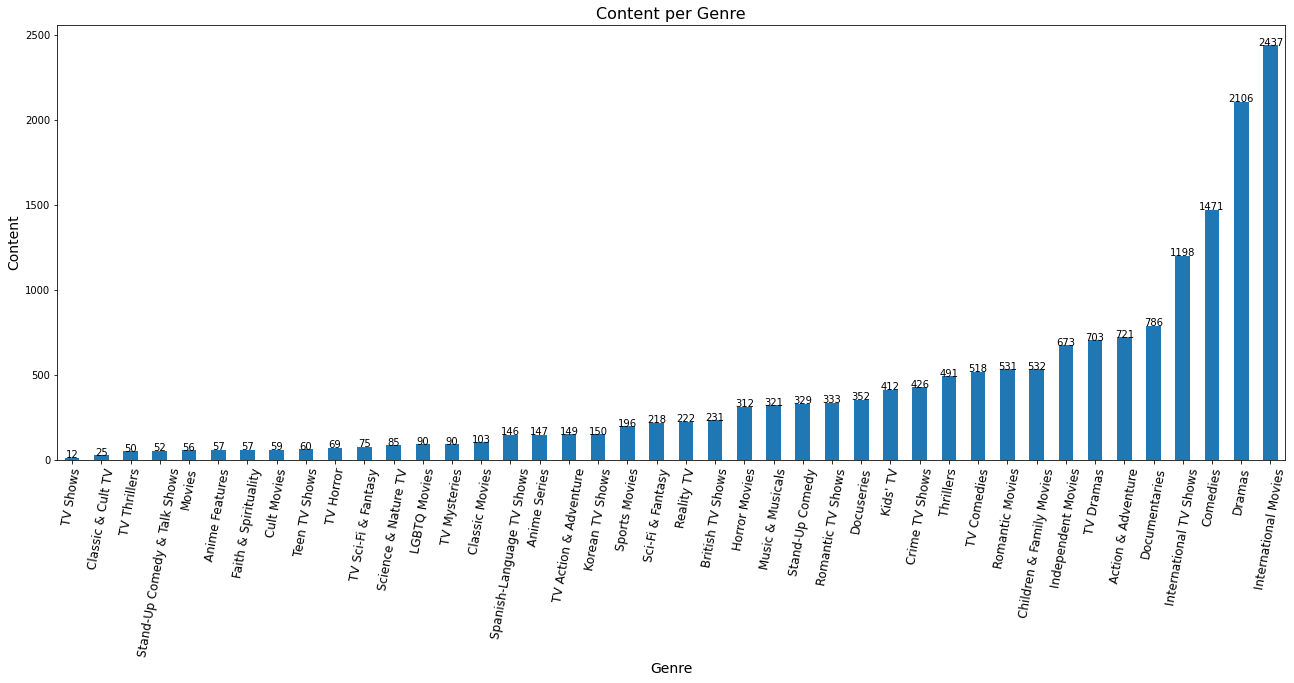

In [ ]:
tempdf = df

#The 'listed_in' column has multiple entries in the same row, so we need to create a seperate row for each entry
tempdf =  tempdf.assign(listed_in=tempdf['listed_in'].str.strip(',').str.replace(', ', ',').str.split(',')).explode('listed_in').reset_index(drop=True)



#We group our data based on the country and keep the 10 countries with the most content
tempdf = tempdf.groupby(['listed_in']).size()


#We plot our data
tempdf.sort_values().plot.bar(figsize = (22,8))
for idx, count in enumerate(list(tempdf.sort_values())):
    plt.text(idx, count, str(count), horizontalalignment='center')
plt.title('Content per Genre', fontsize = 16)
plt.xticks(rotation = 80, fontsize = 12)
plt.xlabel('Genre', fontsize = 14)
plt.ylabel('Content', fontsize = 14)

plt.show()

##Query 9
Who are the directors with the most content per country?

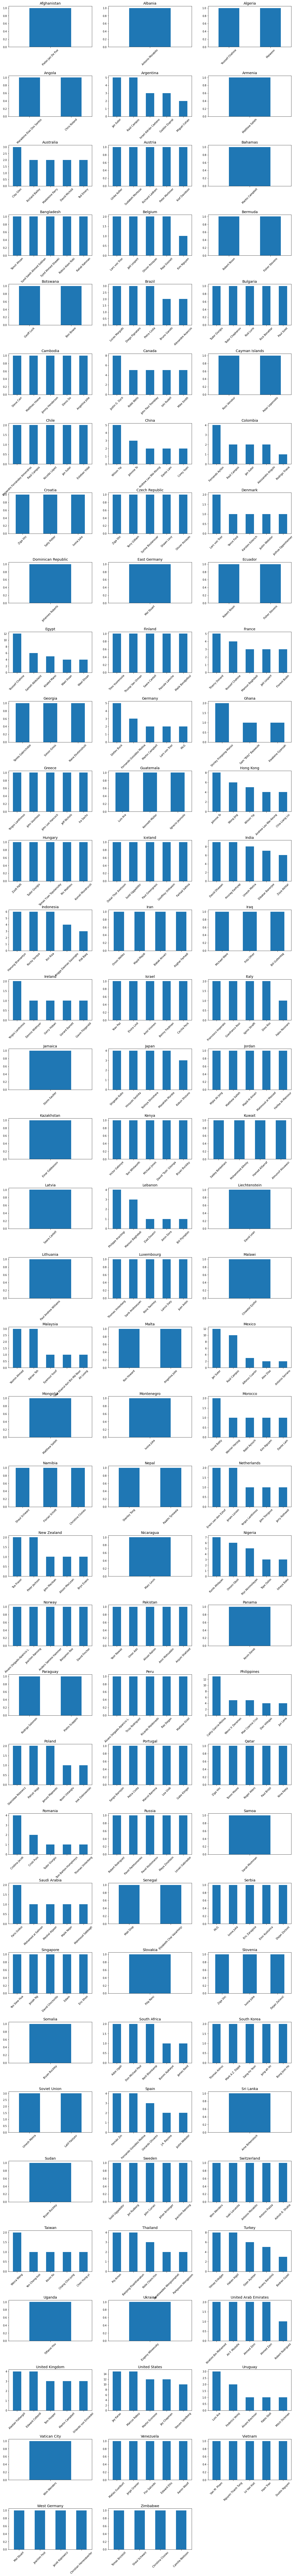

In [ ]:
tempdf = df

#Preprocessing: Deleting rows that contain a NaN value under "country" and "director"
tempdf.dropna(subset = ["country","director"], inplace=True)
tempdf = tempdf.reset_index()


#The 'country' & 'director' columns have multiple entries in the same row, so we need to create a seperate row for each entry
new_tempdf = tempdf.assign(country=tempdf['country'].str.strip(',').str.replace(', ', ',').str.split(',')).explode('country').reset_index(drop=True)
tempdf =  new_tempdf.assign(director=new_tempdf['director'].str.strip(',').str.replace(', ', ',').str.split(',')).explode('director').reset_index(drop=True)


# #We group our data based on the country and cast
tempdf = tempdf.groupby(['country','director']).size().unstack()


fig = plt.figure(figsize = (20, 200))


i=1
for country, row in tempdf.iterrows():
  #Clear NaN values, sort and keep the 5 tops actors with the most movies
  row = row.dropna()
  row = row.sort_values(ascending=False).head(5)
  
  ax = fig.add_subplot(40, 3, i)

  row.plot.bar() 
  ax.set_title(country, fontsize = 14)
  ax.set_xlabel('')
  ax.tick_params('x', labelrotation = 45)
  i+=1
  

plt.subplots_adjust(hspace = 0.7)
plt.show()

##Query 10
Show Netflix's TV Shows based on their number of seasons

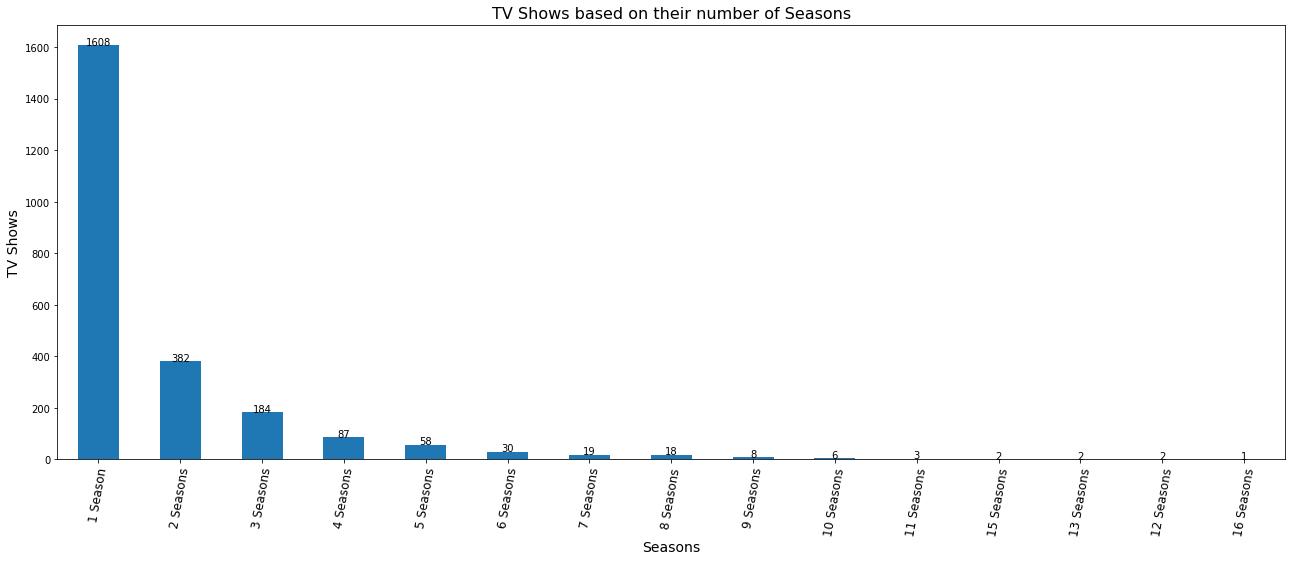

In [ ]:
tempdf = df

tempdf.groupby('type').size()

#Keep only the rows that contain TV Series
tempdf = tempdf[tempdf['type'] == 'TV Show']


#We group our data based on the country and cast
tempdf = tempdf.groupby(['duration']).size()

#We plot our data
tempdf.sort_values(ascending=False).plot.bar(figsize = (22,8))
for idx, count in enumerate(list(tempdf.sort_values(ascending=False))):
    plt.text(idx, count, str(count), horizontalalignment='center')
plt.title('TV Shows based on their number of Seasons', fontsize = 16)
plt.xticks(rotation = 80, fontsize = 12)
plt.xlabel('Seasons', fontsize = 14)
plt.ylabel('TV Shows', fontsize = 14)

plt.show()

##Query 11
Based on a dataset that include IMDB movies, find the top rated movies of Netflix

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


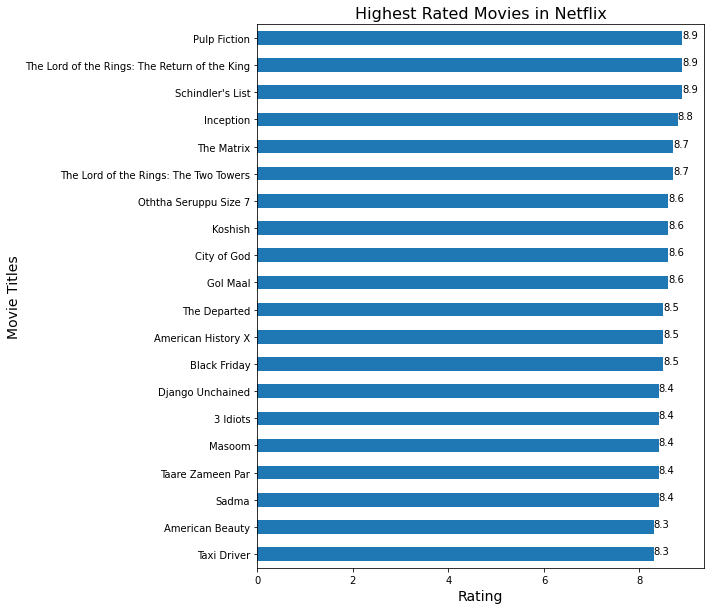

In [ ]:
Location_imdbMovies = r'/content/gdrive/MyDrive/DataMining/Εργασίες/Data Mining Netflix/data/IMDb movies.csv' 

tempdf = df

movies_df = pd.read_csv(Location_imdbMovies)

#Keep only the columns that contain the titles, the release year and the average vote
movie_ratings = movies_df[['original_title','title', 'year', 'avg_vote']]

#Keep only the rows that contain movies and the release year
tempdf_filtered = tempdf[tempdf['type'] == 'Movie'].reset_index()
tempdf_filtered = tempdf_filtered[['title', 'release_year']]
tempdf_filtered.rename(columns={'release_year': 'year'}, inplace=True)

#Combine the original_title and title columns into one
temp1 = movie_ratings[['original_title', 'year', 'avg_vote']]
temp1.rename(columns={'original_title': 'title'}, inplace=True)
temp1.reset_index(drop = True)

movie_ratings_new = temp1.append(movie_ratings[['title', 'year', 'avg_vote']], ignore_index = True)

#Drop the rows where there are duplicate values for title and year
movie_ratings_new = movie_ratings_new.drop_duplicates(
  subset = ['title', 'year'],
  keep = 'last').reset_index(drop = True)


#Merge the dataframe that contains the ratings with the one that contains the netflix movies and drop the NaN values
combined_df = pd.merge(tempdf_filtered, movie_ratings_new, how='left', left_on=['title','year'], right_on = ['title','year']) 
combined_df.dropna(subset = ["avg_vote"], inplace=True)
combined_df = combined_df.sort_values(by='avg_vote', ascending=True)

#Keep only the 20 best rated movies
combined_df = combined_df[['title', 'avg_vote']].tail(20).reset_index(drop = True)
combined_df

#We plot our data
combined_df.plot.barh(x='title', legend=None, figsize = (8,10))
for idx, value in enumerate(list(combined_df['avg_vote'])):
    plt.text(value, idx, str(value), horizontalalignment='left')
plt.title('Highest Rated Movies in Netflix', fontsize = 16)
plt.xlabel('Rating', fontsize = 14)
plt.ylabel('Movie Titles', fontsize = 14)

plt.show()

#Recommendation System

We will keep only the columns 'show_id', 'title' and 'description' from our dataframe.

In [5]:
description_df = df[['show_id', 'title', 'description']]
description_df

show_id  ...                                        description
0         s1  ...  In a future where the elite inhabit an island ...
1         s2  ...  After a devastating earthquake hits Mexico Cit...
2         s3  ...  When an army recruit is found dead, his fellow...
3         s4  ...  In a postapocalyptic world, rag-doll robots hi...
4         s5  ...  A brilliant group of students become card-coun...
...      ...  ...                                                ...
7782   s7783  ...  When Lebanon's Civil War deprives Zozo of his ...
7783   s7784  ...  A scrappy but poor boy worms his way into a ty...
7784   s7785  ...  In this documentary, South African rapper Nast...
7785   s7786  ...  Dessert wizard Adriano Zumbo looks for the nex...
7786   s7787  ...  This documentary delves into the mystique behi...

[7787 rows x 3 columns]

##Preprocessing

In [6]:
def preprocess(description):
  #Tokenize Sentence and convert to lower case
  tokens = word_tokenize(description)
  tokens = [token.lower() for token in tokens]

  #Removing punctuation
  tokens = [token for token in tokens if token.isalnum()]

  #Removing Stopwords
  filtered = [w for w in tokens if not w in stopwords.words('english')]

  #Stemming remaining words
  stemmer = PorterStemmer()
  stems = [stemmer.stem(filter) for filter in filtered]

  return ' '.join(stems)



description_list = []

for idx, row in description_df.iterrows():
  description_list.append(preprocess(row['description']))

description_df.insert(len(description_df.columns), 'mod_description', description_list, True)
description_df.head()

show_id  ...                                    mod_description
0      s1  ...  futur elit inhabit island paradis far crowd sl...
1      s2  ...  devast earthquak hit mexico citi trap survivor...
2      s3  ...  armi recruit found dead fellow soldier forc co...
3      s4  ...  postapocalypt world robot hide fear danger mac...
4      s5  ...  brilliant group student becom expert intent sw...

[5 rows x 4 columns]

##Representation
We will create 2 different representations for each movie, based on the 'description' column of our dataframe.

###boolean Bag of Words (BoW)

In [7]:
vectorizer_bow = CountVectorizer( max_df=0.05, analyzer='word', binary= True, ngram_range=(1, 2))
X_bow = vectorizer_bow.fit_transform(description_df['mod_description'])

###TF-IDF (Term Frequency - Inverse Document Frequency)

In [8]:
vectorizer_tfidf = text.CountVectorizer(max_df=0.05, stop_words='english', ngram_range=(1, 2))
counts = vectorizer_tfidf.fit_transform(description_df['mod_description'])
tfidf = text.TfidfTransformer().fit_transform(counts)

##Comparing Content

###Jaccard/Tanimoto coefficient (BoW)
In order to compare movies from the boolean BoW representation we will use the Jaccard/Tanimoto coefficient.

In [9]:
#sklearn offers the pairwise_distances function that can help us calculate the paiwise 
#distances of "jaccard", however it's too slow so we'll need to use the function below  


# Jaccard similarity function
def jaccard_similarity(X, Y=None):
    """
    Computes the Jaccard score between two sparse matrices or between all pairs in
    one sparse matrix.

    Args:
        X (scipy.sparse.csr_matrix): A sparse matrix.
        Y (scipy.sparse.csr_matrix, optional): A sparse matrix.

    Returns:
        numpy.ndarray: A similarity matrix.
    """

    if Y is None:
        Y = X

    assert X.shape[1] == Y.shape[1] # columns of X must be equal to columns of Y
    # make arrays boolean 
    X = X.astype(bool).astype(int)
    Y = Y.astype(bool).astype(int)

    intersect = X.dot(Y.T)

    x_sum = X.sum(axis=1).A1
    y_sum = Y.sum(axis=1).A1
    xx, yy = np.meshgrid(x_sum, y_sum)
    union = ((xx + yy).T - intersect)

    return (intersect / union).A
    

jaccard_coeff = jaccard_similarity(X_bow)

print(jaccard_coeff)

[[1.         0.         0.01818182 ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.03773585 0.         0.        ]
 [0.01818182 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.03773585 0.         ... 1.         0.         0.04166667]
 [0.         0.         0.         ... 0.         1.         0.02      ]
 [0.         0.         0.         ... 0.04166667 0.02       1.        ]]


###Cosine similarity (TF-IDF)
In order to compare movies from the TF-IDF representation we will use the Cosine similarity.

In [11]:
#from sklearn.metrics.pairwise offers the cosine_similarity function that we'll use.

cos_sim = cosine_similarity(tfidf)

print(cos_sim)

[[1.         0.         0.02229791 ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.03087246 0.         0.        ]
 [0.02229791 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.03087246 0.         ... 1.         0.         0.04426259]
 [0.         0.         0.         ... 0.         1.         0.01664161]
 [0.         0.         0.         ... 0.04426259 0.01664161 1.        ]]


###Building Dictionaries
For each method, we'll make a dictionary that will contain for each movie the 100 more similar movies to it. 

In [14]:
#
# Jaccard / Tanimoto Coefficient
#

# dictionary_jaccard
def jaccard_create_dictionary(jacc_temp, type_j = None):
  
  #The first if with the tag 'singular' is used when we receive a movie description and was to find movies similar to it
  if type_j == 'singular':
    #replacing the first value of 1 with 0
    jacc_temp[0][0] = 0

    #Getting a list that contains the indices of the 100 largest values     
    temp_list = jacc_temp[0].argsort()[-100:][::-1]
      
    #returns list that has 100 most similar movies
    return description_df.iloc[temp_list]['title'].tolist()

  else:
    #replacing the diagonal values of 1 with 0 because every movie is completely similar to itself
    np.fill_diagonal(jacc_temp, 0)

    for idx, row in enumerate(jacc_temp):
      #Getting a list that contains the indices of the 100 largest values 
      temp_list = jacc_temp[idx].argsort()[-100:][::-1]

      #Creating a dictionary that has a movie title as a key and the 100 most similar movies as values
      dictionary_jaccard[description_df.iloc[idx]['title']] = description_df.iloc[temp_list]['title'].tolist()

    return dictionary_jaccard


jacc_temp = jaccard_coeff
dictionary_jaccard = {}

dictionary_jaccard = jaccard_create_dictionary(jacc_temp)

In [13]:
#
# Cosine similarity
#

#Dictionary Cosine similarity
def cosine_create_dictionary(cos_temp, type_j = None):
  
  #The first if with the tag 'singular' is used when we receive a movie description and was to find movies similar to it
  if type_j == 'singular':
    #replacing the first value of 1 with 0
    cos_temp[0][0] = 0

    #Getting a list that contains the indices of the 100 largest values     
    temp_list = cos_temp[0].argsort()[-100:][::-1]
      
    #returns list that has 100 most similar movies
    return description_df.iloc[temp_list]['title'].tolist()
  
  else:    
    #replacing the diagonal values of 1 with 0 because every movie is completely similar to itself
    np.fill_diagonal(cos_temp, 0)

    for idx, row in enumerate(cos_temp):
      #Getting a list that contains the indices of the 100 largest values 
      temp_list = cos_temp[idx].argsort()[-100:][::-1]

      #Creating a dictionary that has a movie title as a key and the 100 most similar movies as values
      dictionary_cosine[description_df.iloc[idx]['title']] = description_df.iloc[temp_list]['title'].tolist()

    return dictionary_cosine


cos_temp = cos_sim
dictionary_cosine = {}

dictionary_cosine = cosine_create_dictionary(cos_temp)

###Comparing Content based on Title
Below we'll make a function that will receive as input a movie/tv series title and will produce the N most similar movies/tv shows to it. Also, we'll be able to choose if we want to use the BoW or the TF-IDF representation for our results.

In [15]:
def recommendation_title(title, N, method = 'bow'):
  if method == 'bow':
    return dictionary_jaccard[title][:N]
  elif method == 'tf-idf':
    return dictionary_cosine[title][:N]

As we can see, for some movies the results are "OK". 

For example, for the horror movie '23:59' the function recommends us some other horror movies that are similar in genre and tone.

In [118]:
recommendation_title('23:59', 10, method='tf-idf')

['Camp X-Ray',
 'The Autopsy of Jane Doe',
 'The Decline',
 'Pizza',
 'Snowden',
 'Una',
 'The Delivery Boy',
 'The Haunting of Hill House',
 'Backtrack',
 'Anjaan: Rural Myths']

Similarly, for the movie 'Django' we get as recommendations other Tarantino/Western movies:


In [119]:
recommendation_title('Django Unchained', 10, method='tf-idf')

['Slow West',
 'Running for Grace',
 '3Below: Tales of Arcadia',
 'Power Rangers Dino Charge',
 'The Bounty Hunter',
 'Ghost Rider',
 'Teenage Bounty Hunters',
 'The Hateful Eight',
 'The Hateful Eight: Extended Version',
 'Mud']

However, things aren't so good for other movies/tv shows:



In [120]:
recommendation_title('American History X', 10, method='bow')

['Good Time',
 'Kickboxer: Vengeance',
 'Divines',
 'Operation Gold Rush',
 'The Man Who Feels No Pain',
 'Diamond City',
 'In Line',
 'Chal Mere Bhai',
 'American Heist',
 "Molly's Game"]

In [121]:
recommendation_title('Pulp Fiction', 10, method='tf-idf')

['Waiting for "Superman"',
 'The Irishman',
 'Sparring',
 'MR. RIGHT',
 'The Hollow Point',
 'Skiptrace',
 'Surviving Escobar - Alias JJ',
 "The Surgeon's Cut",
 'Happy!',
 'Bbuddah Hoga Terra Baap']

This is something that we expected, since building a recommendation system **only** on BoW and TF-IDF is not a really good idea. 

This is due to the fact that words taken out of context lose their meaning. Two completely different movies can have similar words in their description and this will lead in unfavorable results in the recommendation process.

###Comparing Content based on Description

In [24]:
def recommendation_description(description, N, method = 'bow'):
  list_processed = []
  movie_list = []

  #Preprocessing our description and placing it in a list with the other descriptions
  list_processed = description_df['mod_description'].tolist()
  list_processed.insert(0, preprocess(description))
  
  if method == 'bow':
    #Creating a BoW representation based on our data
    vectorizer_bow = CountVectorizer( max_df=0.05, analyzer='word', binary= True, ngram_range=(1, 2))
    rec_bow = vectorizer_bow.fit_transform(list_processed)

    #Creating/Returning a list of similar movies based on the Jaccard coefficient
    movie_list = jaccard_create_dictionary(jaccard_similarity(rec_bow[0], rec_bow), 'singular')
    
    return movie_list[:N]
  
  elif method == 'tf-idf':
    #Creating a TF-IDF representation based on our data
    vectorizer_tfidf = text.CountVectorizer(max_df=0.05, stop_words='english', ngram_range=(1, 2))
    counts = vectorizer_tfidf.fit_transform(list_processed)
    rec_tfidf = text.TfidfTransformer().fit_transform(counts)

    #Creating/Returning a list of similar movies based on cosine similarity
    movie_list = cosine_create_dictionary(cosine_similarity(rec_tfidf[0], rec_tfidf), 'singular')
    
    return movie_list[:N]


recommendation_description('Rescue mission from WW2', 10, method = 'bow')


['The Great Train Robbery',
 'Bird Box',
 'Robocar Poli',
 'Loco Love',
 "Roh's Beauty",
 'Especial 20 años Fútbol de Primera',
 'Light in the Dark',
 'Transformers: Cyberverse',
 'Saheb Bibi Golaam',
 'The Rift: The Dark Side of the Moon']